In [1]:
import geopandas as gpd
import pandas as pd
import pickle
import numpy as np
import os
import copy
from climada_petals.engine.networks.nw_base import Network
from climada_petals.engine.networks.nw_calcs import Graph
import climada_petals.engine.networks.nw_utils as nwu
import seaborn as sns

from climada.util import coordinates as u_coords

In [2]:
def load_dict(path_dict):
    # load any dict saved as pkl
    with open(path_dict, 'rb') as stats_dict:
         stats_dict = pickle.load(stats_dict)
    return stats_dict

def save_dict(dict_var, save_path):
    # save any dict as pkl
    with open(save_path, 'wb') as f:
        pickle.dump(dict_var, f) 

### Cascade State and Access State

In [3]:

def get_cascstate(gdf):
    """
    for infrastructure items. 0: functional state, 1: dysfunctional state, 
    2: cascaded dysfunctional state
    """
    casc_state = [0]* len(gdf)
    for i in range(len(gdf)):
        if ((gdf.func_tot.iloc[i]==0) & (gdf.func_internal.iloc[i]==0)):
            casc_state[i] = 1
        elif ((gdf.func_tot.iloc[i] ==0) & (gdf.func_internal.iloc[i] >0)):
            casc_state[i] = 2
    return casc_state                                   

def get_accessstates(gdf, node_gdf_orig):
    """
    1 - accessible, 0 - inaccessible from beginning on, -1 - disrupted due to 
    disaster. Careful - Changes gdf entries!
    """
    
    services = [colname for colname in gdf.columns if 'actual_supply_' in colname] 
    for service in services:
        serv_level = gdf[gdf.ci_type=='people'][service].values
        serv_level_orig = node_gdf_orig[node_gdf_orig.ci_type=='people'][service].values
        serv_level[(serv_level==0.) & (serv_level_orig==1.)]= -1.
        gdf.loc[gdf.ci_type=='people', service] = serv_level
    return gdf
 
def get_casc_and_access_states(gdf, gdf_nodes_orig, save_path=None):
    """
    re-calculate cascade-states for now, irrespective of whether it's been calculated.
    """
    gdf['casc_state'] = get_cascstate(gdf)
    gdf = get_accessstates(gdf, gdf_nodes_orig)
    if save_path is not None:
        gdf.to_feather(save_path)
    return gdf

In [4]:
def access_rate_conversion(base_stat_dict, gdf_nodes_orig, abs_num=False):
    """
    from number of ppl without access to number of poeple with access
    and access rates
    """
    total_pop = gdf_nodes_orig[gdf_nodes_orig.ci_type=='people'].counts.sum()
    access_rate_dict = {}
    factor = 1/total_pop if not abs_num else 1
    for key, value in base_stat_dict.items():
        access_rate_dict[key] = (total_pop-value)* factor
    return access_rate_dict


In [5]:
def disruption_rate_conversion(event_stats_dict, access_num_dict):
    """
    disruption rate: number of people who lost service access relative
    to those with initial service access
    """
    disruption_rate_dict = copy.deepcopy(event_stats_dict)
    for haz_type, haz_dict in disruption_rate_dict.items():
        for adp_scen, imp_dict in haz_dict.items():
            for bs, event_imp in imp_dict.items():
                disruption_rate_dict[haz_type][adp_scen][bs] = event_imp/access_num_dict[bs]
    return disruption_rate_dict

### Implementation

In [6]:
haz_type = 'TC' # or FL or TCFL
cntry = 'Mozambique'
iso3 = u_coords.country_to_iso(cntry)

In [7]:


    # paths
    path_proj_folder = '/cluster/work/climate/evelynm/nw_outputs/MOZ/moz_project/'
    path_save_plots = path_proj_folder+'plots/'
    path_nodes = path_proj_folder+'cis_nw_nodes'
    path_edges = path_proj_folder+'cis_nw_edges'
    path_base_stats = path_proj_folder+f'base_stats_{iso3}.pkl'
    if not os.path.exists(path_save_plots):
        os.makedirs(path_save_plots)
    if not os.path.exists(path_proj_folder+'old/'):
        os.makedirs(path_proj_folder+'old/')

### Load base network & graph

In [8]:
ci_network_base = Network(nodes=gpd.read_feather(path_nodes), edges=gpd.read_feather(path_edges))
ci_graph_base = Graph(ci_network_base, directed=True)

### Load result gdfs and result total stats

In [9]:
dict_result_gdfs = {'TC':{}, 'FL':{}, 'TCFL':{}}
for haz_type in ['TC', 'FL', 'TCFL']:
    for adp_scen in ['base','MS1', 'MS2', 'MS3', 'MS4', 'MS5']:
        dict_result_gdfs[haz_type][adp_scen] = gpd.read_feather(path_proj_folder+f'cascade_results_{haz_type}_{adp_scen}')
    # for adp_scen in ['base','MS1', 'MS2', 'MS3']:
        #dict_result_gdfs[haz_type][adp_scen]['Level'] = 0
        #dict_result_gdfs[haz_type][adp_scen].loc[
        #    (dict_result_gdfs[haz_type][adp_scen].ci_type=='health'),'Level'] = \
        #ci_network_base.nodes[(ci_network_base.nodes.ci_type=='health')].Level

In [10]:
nw_nodes_4 = gpd.read_feather(path_proj_folder+'cis_nw_nodes_m4')
dict_result_gdfs[haz_type]['MS4']['Level'] = 0
dict_result_gdfs[haz_type]['MS4'].loc[
            (dict_result_gdfs[haz_type]['MS4'].ci_type=='health'),'Level'] = \
        nw_nodes_4[(nw_nodes_4.ci_type=='health')].Level

In [179]:
dict_result_gdfs[haz_type]['MS4'].loc[
            (dict_result_gdfs[haz_type]['MS4'].ci_type=='health')& (dict_result_gdfs[haz_type]['MS4'].Level>2)]

,ci_type,func_internal,func_tot,imp_dir,geometry,actual_supply_celltower_people,actual_supply_education_people,actual_supply_health_people,actual_supply_power_line_people,actual_supply_road_people,counts,casc_state,Level
478116,health,0,0,0.600531,POINT (34.87402 -19.85082),0.0,0.0,1.0,0.0,0.0,NaN,1,4.0
478146,health,0,0,1.600531,POINT (34.87521 -19.84903),0.0,0.0,1.0,0.0,0.0,NaN,1,4.0
478186,health,1,1,0.000000,POINT (39.87422 -13.10498),0.0,0.0,1.0,0.0,0.0,NaN,0,4.0
478889,health,1,1,0.000000,POINT (32.58613 -25.93040),0.0,0.0,1.0,0.0,0.0,NaN,0,4.0
478894,health,1,1,0.000000,POINT (33.00388 -24.52850),0.0,0.0,1.0,0.0,0.0,NaN,0,3.0
478897,health,1,1,0.000000,POINT (32.54401 -25.94766),0.0,0.0,1.0,0.0,0.0,NaN,0,4.0
478902,health,0,0,0.429180,POINT (33.47829 -19.10905),0.0,0.0,1.0,0.0,0.0,NaN,1,3.0
478905,health,1,1,0.000000,POINT (39.26124 -15.12326),0.0,0.0,1.0,0.0,0.0,NaN,0,4.0
478926,health,1,1,0.000000,POINT (32.43858 -25.96728),0.0,0.0,1.0,0.0,0.0,NaN,0,3.0
478927,health,1,1,0.000000,POINT (32.61106 -25.94286),0.0,0.0,1.0,0.0,0.0,NaN,0,4.0


In [11]:
dict_result_stats = {'TC':{}, 'FL':{}, 'TCFL':{}}
for haz_type in ['TC', 'FL', 'TCFL']:
    for adp_scen in ['base','MS1', 'MS2', 'MS3', 'MS4', 'MS5']:
        dict_result_stats[haz_type][adp_scen] = load_dict(path_proj_folder+f'service_stats_idai_{haz_type}_{adp_scen}.pkl')

In [12]:
dict_result_stats

{'TC': {'base': {'power': 4553453.019901276,
   'healthcare': 3105273.122065544,
   'education': 6323812.534892082,
   'telecom': 6878039.101071358,
   'mobility': 867730.4972352982,
   'people': 1929088.979181837},
  'MS1': {'power': 4553453.019901276,
   'healthcare': 3012762.120341301,
   'education': 6323812.534892082,
   'telecom': 6878039.101071358,
   'mobility': 867730.4972352982,
   'people': 1929088.979181837},
  'MS2': {'power': 4013798.2443552017,
   'healthcare': 3105273.122065544,
   'education': 6175367.798254967,
   'telecom': 6729488.756750107,
   'mobility': 867730.4972352982,
   'people': 1929088.979181837},
  'MS3': {'power': 4524457.060035706,
   'healthcare': 2945094.3408699036,
   'education': 6219358.750647545,
   'telecom': 6760619.23668766,
   'mobility': 867730.4972352982,
   'people': 1929088.979181837},
  'MS4': {'power': 4553453.019901276,
   'healthcare': 3106852.8817510605,
   'education': 6323812.534892082,
   'telecom': 6878039.101071358,
   'mobility'

Compute total affected people from compound hazards (not computed initally)

In [13]:
for adp_scen in ['base', 'MS1', 'MS2', 'MS3', 'MS4', 'MS5']:
    dict_result_stats['TCFL'][adp_scen]['people'] = \
    dict_result_gdfs['TC'][adp_scen]['imp_dir'][dict_result_gdfs['TC'][adp_scen].ci_type=='people'].sum()+ \
    dict_result_gdfs['FL'][adp_scen]['imp_dir'][(dict_result_gdfs['FL'][adp_scen].ci_type=='people')&
                                              (dict_result_gdfs['TC'][adp_scen]['imp_dir']==0)].sum()

In [21]:
dict_result_gdfs['TCFL']['MS4'].columns

Index(['ci_type', 'func_internal', 'func_tot', 'imp_dir', 'geometry',
       'actual_supply_celltower_people', 'actual_supply_education_people',
       'actual_supply_health_people', 'actual_supply_power_line_people',
       'actual_supply_road_people', 'counts', 'casc_state'],
      dtype='object')

In [195]:
# cascade states -> only necesssary first time
""" 
for haz_type in ['TC', 'FL', 'TCFL']:
    for adp_scen in ['base','MS1', 'MS2', 'MS3']:
        dict_result_gdfs[haz_type][adp_scen] = get_casc_and_access_states(dict_result_gdfs[haz_type][adp_scen],
                                                                         ci_network_base.nodes,
                                                                         save_path=path_proj_folder+f'cascade_results_{haz_type}_{adp_scen}')
                                                                         
                                                                         
for haz_type in ['TC', 'FL', 'TCFL']:
    dict_result_gdfs[haz_type]['MS4'] = get_casc_and_access_states(dict_result_gdfs[haz_type][adp_scen],
                                                                   gpd.read_feather(path_proj_folder+'cis_nw_nodes_m4'),
                                                                         save_path=path_proj_folder+f'cascade_results_{haz_type}_{adp_scen}')

for haz_type in ['TC', 'FL', 'TCFL']:
    dict_result_gdfs[haz_type]['MS5'] = get_casc_and_access_states(dict_result_gdfs[haz_type][adp_scen],
                                                                   gpd.read_feather(path_proj_folder+'cis_nw_nodes_m5'),
                                                                         save_path=path_proj_folder+f'cascade_results_{haz_type}_{adp_scen}')        """   


/scratch/tmp.8260903.evelynm/ipykernel_84977/1141886047.py:35: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_feather(save_path)


In [22]:
    #load base files 
    base_stat_dict = load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    access_stat_dict = access_rate_conversion(base_stat_dict, ci_network_base.nodes)
    access_num_dict = access_rate_conversion(base_stat_dict, ci_network_base.nodes, abs_num=True)
    

In [23]:
print(base_stat_dict)
print(access_num_dict)

{'power': 20171749.238749504, 'healthcare': 8825538.513594627, 'education': 11227708.927436829, 'telecom': 10003334.346621513, 'mobility': 9598570.220466614, 'people': 0}
{'power': 9305266.849009514, 'healthcare': 20651477.57416439, 'education': 18249307.16032219, 'telecom': 19473681.741137505, 'mobility': 19878445.867292404, 'people': 29477016.087759018}


In [24]:
# M4 has (slightly) different base state because more hospitals to start with!
base_stat_dict_m4 = load_dict(path_proj_folder+f'base_stats_{iso3}_m4.pkl')
access_num_dict_m4 = access_rate_conversion(base_stat_dict_m4, ci_network_base.nodes, abs_num=True)

In [25]:
print(base_stat_dict_m4)
print(access_num_dict_m4)

{'power': 20171749.238749504, 'healthcare': 8818511.99309063, 'education': 11227708.927436829, 'telecom': 10003334.346621513, 'mobility': 9598570.220466614}
{'power': 9305266.849009514, 'healthcare': 20658504.09466839, 'education': 18249307.16032219, 'telecom': 19473681.741137505, 'mobility': 19878445.867292404}


In [26]:
access_num_dict_m4['healthcare']/access_num_dict['healthcare']

1.000340242991271

In [27]:
dict_result_stats_rel = disruption_rate_conversion(dict_result_stats, access_num_dict)

In [199]:
dict_result_stats_rel

{'TC': {'base': {'power': 0.48934147658387267,
   'healthcare': 0.15036566322742603,
   'education': 0.3465234312369608,
   'telecom': 0.35319664727506195,
   'mobility': 0.04365182786563031,
   'people': 0.06544383506928077},
  'MS1': {'power': 0.48934147658387267,
   'healthcare': 0.14588603210214632,
   'education': 0.3465234312369608,
   'telecom': 0.35319664727506195,
   'mobility': 0.04365182786563031,
   'people': 0.06544383506928077},
  'MS2': {'power': 0.4313469252934369,
   'healthcare': 0.15036566322742603,
   'education': 0.33838916425723314,
   'telecom': 0.3455683853831444,
   'mobility': 0.04365182786563031,
   'people': 0.06544383506928077},
  'MS3': {'power': 0.48622539616016547,
   'healthcare': 0.1426093765103909,
   'education': 0.3407997189158902,
   'telecom': 0.3471669777988657,
   'mobility': 0.04365182786563031,
   'people': 0.06544383506928077},
  'MS4': {'power': 0.48934147658387267,
   'healthcare': 0.15044215943356157,
   'education': 0.3465234312369608,
  

## Compute structural & functional impacts (reductions)

In [48]:
import climada.util.coordinates as u_coords

dict_result_gdfs['TC']['base'] = dict_result_gdfs['TC']['base'].set_crs(epsg=4326)
length_vector = u_coords.compute_geodesic_lengths(dict_result_gdfs['TC']['base'])
for haz_type in ['TC', 'FL', 'TCFL']:
    for adp_scen in ['base','MS1', 'MS2', 'MS3']:
        dict_result_gdfs[haz_type][adp_scen]['length'] = length_vector

In [49]:
df_imp_dir = pd.DataFrame(dict_result_gdfs['TCFL']['base'].groupby('ci_type').imp_dir.sum()).rename({'imp_dir':'base'}, axis=1)

In [50]:
for adp_scen in ['MS1', 'MS2', 'MS3', 'MS4', 'MS5']:
    df_imp_dir[adp_scen] = dict_result_gdfs['TCFL'][adp_scen].groupby('ci_type').imp_dir.sum().values
df_imp_dir 

,base,MS1,MS2,MS3,MS4,MS5
ci_type,,,,,,
celltower,4.349669e+01,4.349669e+01,4.349669e+01,4.349669e+01,4.349669e+01,4.349669e+01
education,9.513423e+01,9.513423e+01,9.513423e+01,9.513423e+01,9.513423e+01,9.513423e+01
health,9.477143e+01,7.401619e+01,9.477143e+01,8.593079e+01,9.477143e+01,9.477143e+01
people,0.000000e+00,2.261641e+06,2.261641e+06,2.261641e+06,2.261641e+06,2.261641e+06
power_line,1.705415e+05,1.709295e+05,2.795950e+04,9.739800e+04,1.700705e+05,1.700705e+05
power_plant,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
road,1.466436e+08,1.466436e+08,6.115559e+07,1.039031e+08,1.466436e+08,1.466436e+08


In [51]:
new_row = {adp_scen: dict_result_gdfs[haz_type][adp_scen][
    (dict_result_gdfs[haz_type][adp_scen].ci_type=='power_line') &
    (dict_result_gdfs[haz_type][adp_scen].geometry.type=='Point')].imp_dir.sum() for adp_scen in ['base','MS1', 'MS2', 'MS3', 'MS4', 'MS5']} 

In [52]:
df_imp_dir = df_imp_dir.append(pd.Series(new_row, index=df_imp_dir.columns, name='substation'))

In [53]:
df_imp_red = (df_imp_dir.T/df_imp_dir.base.values.T-1)*100
df_imp_red.pop('power_plant')
df_imp_red.pop('people')
df_imp_red.iloc[1:,]

ci_type,celltower,education,health,power_line,road,substation
MS1,0.0,0.0,-21.900312,0.227511,0.000000,0.000000
MS2,0.0,0.0,0.000000,-83.605457,-58.296444,-88.571429
MS3,0.0,0.0,-9.328377,-42.888974,-29.145835,-54.285714
MS4,0.0,0.0,0.000000,-0.276179,0.000000,0.000000
MS5,0.0,0.0,0.000000,-0.276179,0.000000,0.000000


<AxesSubplot: ylabel='ci_type'>

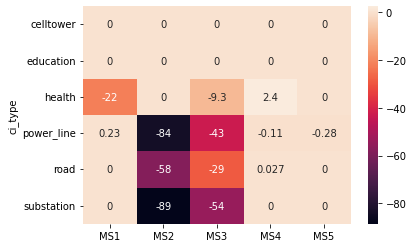

In [206]:
sns.heatmap(df_imp_red.iloc[1:,].T, annot=True)

In [ ]:
for adp_scen in ['base','MS1', 'MS2', 'MS3']:
    print(dict_result_gdfs['TCFL'][adp_scen].groupby('ci_type', 'func_tot')['length'].sum())

In [137]:
print(len(imp_tc[(imp_tc.ci_type=='power_line')&(imp_tc.geometry.type=='LineString')&(imp_tc.imp_dir>0)] ))
print(len(imp_tc[(imp_tc.ci_type=='power_line')&(imp_tc.geometry.type=='LineString')&(imp_tc.imp_dir>200)] ))
print(len(imp_tc[(imp_tc.ci_type=='power_line')&(imp_tc.geometry.type=='LineString')&(imp_tc.imp_dir/imp_tc['length']>0.1)] ))

1997
174
161


<AxesSubplot: >

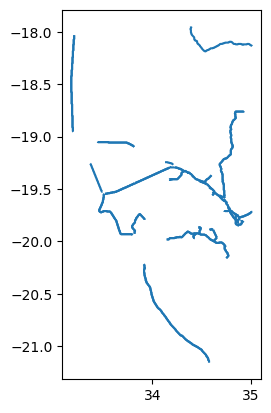

In [139]:
imp_tc[(imp_tc.ci_type=='power_line')&(imp_tc.geometry.type=='LineString')&(imp_tc.imp_dir>200)].plot()

In [143]:
len(imp_tc[(imp_tc.ci_type=='power_line')&(imp_tc.geometry.type=='LineString')&(
    (imp_tc.imp_dir/imp_tc['length']>0.1)|(imp_tc.imp_dir>200))])

189

In [149]:
imp_tc[(imp_tc.ci_type=='road')&(imp_tc.geometry.type=='LineString')&(
    (imp_tc.imp_dir/imp_tc['length']>0.1)|(imp_tc.imp_dir>500))]['length'].sum()/1000

216913.90412578257

In [150]:
imp_tc[(imp_tc.ci_type=='road')&(imp_tc.geometry.type=='LineString')&(
    (imp_tc.imp_dir/imp_tc['length']>0.1))]['length'].sum()/1000

194755.97094525865

In [155]:
imp_tc[(imp_tc.ci_type=='road')&(imp_tc.geometry.type=='LineString')&(
    (imp_tc.imp_dir/imp_tc['length']>0.3))]['length'].sum()/1000

30432.55950103536

In [163]:
imp_tc[(imp_tc.ci_type=='road')&(imp_tc.geometry.type=='LineString')&(
    (imp_tc.imp_dir>500)&(imp_tc.imp_dir/imp_tc['length']>0.2))]['length'].sum()/1000

139848.19413322

In [176]:
len(imp_tc[(imp_tc.ci_type=='road')&(imp_tc.geometry.type=='LineString')&(
   (imp_tc.imp_dir>500))])

33874

In [175]:
len(imp_tc[(imp_tc.ci_type=='road')&(imp_tc.geometry.type=='LineString')&(
   (imp_tc.imp_dir>1000))])

22824

<AxesSubplot: >

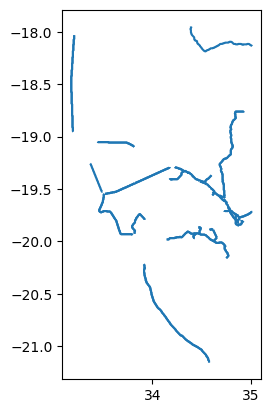

In [170]:
imp_tc[(imp_tc.ci_type=='power_line')&(imp_tc.func_internal<1)].plot()

### Overview plots

In [29]:
#pd.DataFrame.from_dict(dict_result_stats_rel, orient='index')
df_result_stats_rel = pd.concat({k: pd.DataFrame(v).T for k, v in dict_result_stats_rel.items()}, axis=1).T

for adp_scen in ['MS1', 'MS2', 'MS3', 'MS4', 'MS5']:
    df_result_stats_rel[adp_scen] = (df_result_stats_rel[adp_scen].values-df_result_stats_rel['base'].values)/df_result_stats_rel['base'].values
df_result_stats_rel[['base','MS1', 'MS2', 'MS3','MS4', 'MS5']]*=100

In [30]:
df_result_stats_rel

base       MS1         MS2        MS3       MS4  \
TC   power       48.934148  0.000000  -11.851550  -0.636791  0.000000   
     healthcare  15.036566 -2.979158    0.000000  -5.158283  0.050873   
     education   34.652343  0.000000   -2.347393  -1.651753  0.000000   
     telecom     35.319665  0.000000   -2.159778  -1.707171  0.000000   
     mobility     4.365183  0.000000    0.000000   0.000000  0.000000   
     people       6.544384  0.000000    0.000000   0.000000  0.000000   
FL   power        2.097864  0.000000 -100.000000 -25.073260  0.000000   
     healthcare   3.255259 -4.186510  -80.429703 -14.550545 -0.038579   
     education    2.895826  0.000000  -45.275949 -10.093028  0.000000   
     telecom      0.610667  0.000000  -57.670383 -10.208273  0.000000   
     mobility     5.569542  0.000000  -84.734864 -13.444441  0.000000   
     people       1.128175  0.000000    0.000000   0.000000  0.000000   
TCFL power       49.146897  0.000000  -12.233131  -1.021068  0.000000   
     healthcare  16.264766 -2.854562   -1.114283  -2.752734  0.032253   
     education   35.287301  0.000000   -2.704672  -1.962668  0.000000   
     telecom     35.319665  0.000000   -2.159778  -2.567082  0.000000   
     mobility     7.193636  0.000000  -24.760062  -3.595126  0.000000   
     people       6.687543  0.000000    0.000000   0.000000  0.000000   

                       MS5  
TC   power        0.000000  
     healthcare -56.015750  
     education    0.000000  
     telecom      0.000000  
     mobility     0.000000  
     people       0.000000  
FL   power        0.000000  
     healthcare  -6.459219  
     education    0.000000  
     telecom      0.000000  
     mobility     0.000000  
     people       0.000000  
TCFL power        0.000000  
     healthcare -49.796500  
     education    0.000000  
     telecom      0.000000  
     mobility     0.000000  
     people       0.000000

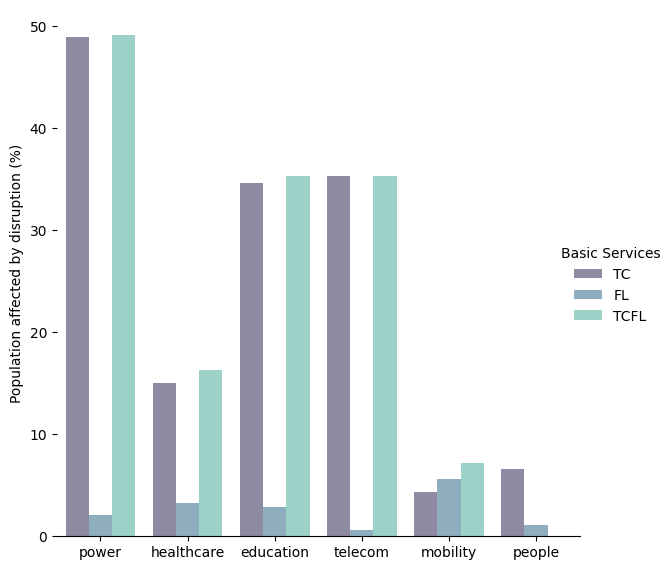

In [46]:
# code for annotated barplot
import matplotlib.pyplot as plt

g = sns.catplot(
    data=df_result_stats_rel.reset_index().rename({'level_0':'haz_type', 'level_1':'service'}, axis=1),
    kind="bar", x="service", y='base', hue='haz_type',  palette="mako", alpha=.6, height=6)
#g.set_xticklabels(["TC Winds", "Flooding", "Compound Wind & Flooding"])
g.despine(left=True)    
g.set_axis_labels("", "Population affected by disruption (%)")
g.legend.set_title("Basic Services")


In [209]:
data = df_result_stats_rel.reset_index().rename({'level_0':'haz_type', 'level_1':'service'}, axis=1)
data

,haz_type,service,base,MS1,MS2,MS3,MS4,MS5
0,TC,power,48.934148,0.000000,-11.851550,-0.636791,0.000000,0.00000
1,TC,healthcare,15.036566,-2.979158,0.000000,-5.158283,0.050873,-56.01575
2,TC,education,34.652343,0.000000,-2.347393,-1.651753,0.000000,0.00000
3,TC,telecom,35.319665,0.000000,-2.159778,-1.707171,0.000000,0.00000
4,TC,mobility,4.365183,0.000000,0.000000,0.000000,0.000000,0.00000
5,TC,people,6.544384,0.000000,0.000000,0.000000,0.000000,0.00000
6,FL,power,2.097864,0.000000,-100.000000,-25.073260,0.000000,0.00000
7,FL,healthcare,3.255259,-4.186510,-80.429703,-14.550545,-0.038579,0.00000
8,FL,education,2.895826,0.000000,-45.275949,-10.093028,0.000000,0.00000
9,FL,telecom,0.610667,0.000000,-57.670383,-10.208273,0.000000,0.00000


In [210]:
dir_affected

NameError: name 'dir_affected' is not defined

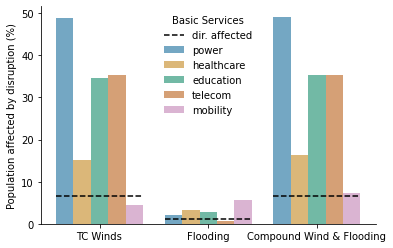

In [31]:
import matplotlib.pyplot as plt

# code for annotated barplot
data = df_result_stats_rel.reset_index().rename({'level_0':'haz_type', 'level_1':'service'}, axis=1)
dir_affected = data[data['service']=='people']
data = data[data['service']!='people']

fig, ax = plt.subplots(1,1)
g = sns.barplot(
    data=data,
    x="haz_type", y='base', hue='service',  palette="colorblind", alpha=.6, ax=ax)
g.set_xticklabels(["TC Winds", "Flooding", "Compound Wind & Flooding"])
#g.despine(left=True)    
plt.ylabel("Population affected by disruption (%)")
plt.xlabel("")
plt.hlines(dir_affected[dir_affected.haz_type=='TC'].base,-0.4,0.4,'k', '--', label='dir. affected')
plt.hlines(dir_affected[dir_affected.haz_type=='FL'].base,0.6,1.4,'k', '--', )
plt.hlines(dir_affected[dir_affected.haz_type=='TCFL'].base,1.6,2.4,'k', '--', )

plt.legend(frameon=False, title="Basic Services")
sns.despine()
plt.savefig(path_save_plots+'multihaz_multiimp_base.png')
#(y, xmin, xmax, colors, linestyles)

In [34]:
df_reindexed = df_result_stats_rel.reset_index().rename({'level_0':'haz_type', 'level_1':'service'}, axis=1)

In [35]:
df_reindexed_ada = df_reindexed[df_reindexed.service!='people']

In [36]:
df_reindexed_ada.pop('base')

0     48.934148
1     15.036566
2     34.652343
3     35.319665
4      4.365183
6      2.097864
7      3.255259
8      2.895826
9      0.610667
10     5.569542
12    49.146897
13    16.264766
14    35.287301
15    35.319665
16     7.193636
Name: base, dtype: float64

In [37]:
df_reindexed_ada

,haz_type,service,MS1,MS2,MS3,MS4,MS5
0,TC,power,0.000000,-11.851550,-0.636791,0.000000,0.000000
1,TC,healthcare,-2.979158,0.000000,-5.158283,0.050873,-56.015750
2,TC,education,0.000000,-2.347393,-1.651753,0.000000,0.000000
3,TC,telecom,0.000000,-2.159778,-1.707171,0.000000,0.000000
4,TC,mobility,0.000000,0.000000,0.000000,0.000000,0.000000
6,FL,power,0.000000,-100.000000,-25.073260,0.000000,0.000000
7,FL,healthcare,-4.186510,-80.429703,-14.550545,-0.038579,-6.459219
8,FL,education,0.000000,-45.275949,-10.093028,0.000000,0.000000
9,FL,telecom,0.000000,-57.670383,-10.208273,0.000000,0.000000
10,FL,mobility,0.000000,-84.734864,-13.444441,0.000000,0.000000


In [38]:
df_reindexed_ada_hc= df_reindexed_ada[df_reindexed_ada.service=='healthcare']

In [39]:
df_reindexed_ada_tcfl  = df_reindexed_ada[df_reindexed_ada.haz_type=='TCFL']

In [40]:
df_reindexed_ada_tcfl.pop('haz_type')

12    TCFL
13    TCFL
14    TCFL
15    TCFL
16    TCFL
Name: haz_type, dtype: object

In [41]:
df_reindexed_ada_hc = df_reindexed_ada_hc.melt(id_vars=["haz_type", "service"], 
        var_name="adp_scen",value_name="impact_reduction")


In [45]:
df_reindexed_ada_hc['impact_reduction'] = df_reindexed_ada_hc['impact_reduction']-0.5 # add irrelevant minus for better plotting

In [100]:
measure_dict = {'MS1' : 'SAM1',
               'MS2' : 'SAM2',
               'MS3' : 'SAM3',
               'MS4' : 'NAM1',
               'MS5' : 'NAM2',}
df_reindexed_ada_hc['adp_scen'] = df_reindexed_ada_hc.apply(lambda row: measure_dict[row.adp_scen], axis=1)

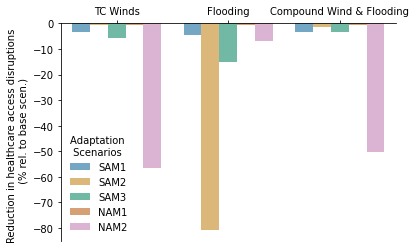

In [101]:
fig, ax = plt.subplots(1,1)
g = sns.barplot(
    data=df_reindexed_ada_hc, x='haz_type',y='impact_reduction', hue='adp_scen', palette='colorblind', alpha=.6, ax=ax)
g.set_xticklabels(["TC Winds", "Flooding", "Compound Wind & Flooding"])
plt.legend(frameon=False, title='Adaptation \n Scenarios')
plt.ylabel("Reduction in healthcare access disruptions  \n (% rel. to base scen.)", multialignment='center')
plt.xlabel("")
sns.despine(top=False, bottom=True)
plt.savefig(path_save_plots+'multihaz_hc_ada.png')

In [226]:
df_reindexed_ada_tcfl = df_reindexed_ada[(df_reindexed_ada.haz_type=='TCFL')]

In [227]:
df_reindexed_ada_tcfl

,haz_type,service,MS1,MS2,MS3,MS4,MS5
12,TCFL,power,0.000000,-12.233131,-1.021068,0.000000,0.0000
13,TCFL,healthcare,-2.854562,-1.114283,-2.752734,0.032253,-49.7965
14,TCFL,education,0.000000,-2.704672,-1.962668,0.000000,0.0000
15,TCFL,telecom,0.000000,-2.159778,-2.567082,0.000000,0.0000
16,TCFL,mobility,0.000000,-24.760062,-3.595126,0.000000,0.0000


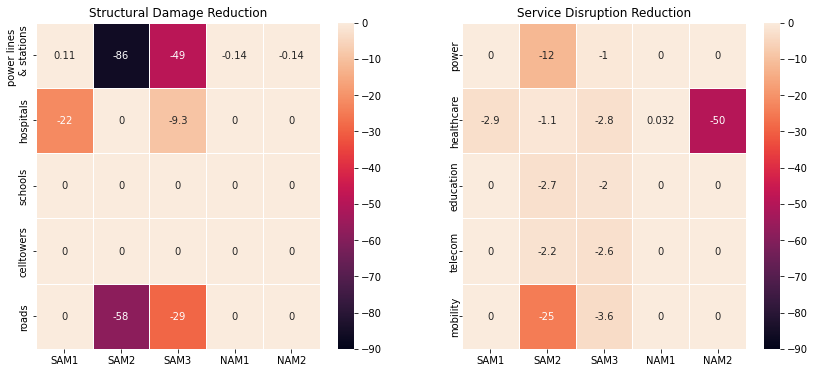

In [105]:
import matplotlib as mpl

df_imp_red['power'] = (df_imp_red['power_line']+df_imp_red['substation'])/2
f, axes = plt.subplots(1,2, figsize=(14, 6), sharey=False)

sns.heatmap(df_imp_red.iloc[1:].T.loc[['power', 'health', 'education', 'celltower', 'road']], annot=True, 
            yticklabels=['power lines \n & stations', 'hospitals', 'schools', 'celltowers', 'roads'],
            xticklabels=['SAM1', 'SAM2', 'SAM3', 'NAM1', 'NAM2'],
            linewidths=.5, vmin=-90, vmax=0, ax=axes[0], cbar=True)
axes[0].set_ylabel('')
plt.yticks(rotation='vertical', rotation_mode="anchor", horizontalalignment='center', wrap=True)
axes[0].title.set_text('Structural Damage Reduction')

hm2 = sns.heatmap(df_reindexed_ada_tcfl[['MS1', 'MS2', 'MS3', 'MS4', 'MS5']], 
            xticklabels=['SAM1', 'SAM2', 'SAM3', 'NAM1', 'NAM2'],
            annot=True, yticklabels=df_reindexed_ada_tcfl.service,
            linewidths=.5, vmin=-90, vmax=0, ax=axes[1],  cbar=True)
axes[1].title.set_text('Service Disruption Reduction')
plt.ylabel('')

#cbar = plt.colorbar(hm2, ax=axes.ravel().tolist(), shrink=0.95)

# yticklabels=df_reindexed_ada_tcfl.service,
plt.savefig(path_save_plots+'co_benefits.png', dpi=300)

In [102]:
df_reindexed_ada_tcfl = df_reindexed_ada_tcfl.melt(id_vars=["haz_type", "service"], 
        var_name="adp_scen",value_name="impact_reduction")

In [103]:
df_reindexed_ada_tcfl

,haz_type,service,adp_scen,impact_reduction
0,TCFL,power,MS1,0.000000
1,TCFL,education,MS1,0.000000
2,TCFL,telecom,MS1,0.000000
3,TCFL,mobility,MS1,0.000000
4,TCFL,power,MS2,-12.233131
5,TCFL,education,MS2,-2.704672
6,TCFL,telecom,MS2,-2.159778
7,TCFL,mobility,MS2,-24.760062
8,TCFL,power,MS3,-1.021068
9,TCFL,education,MS3,-1.962668


ValueError: could not convert string to float: 'TCFL'

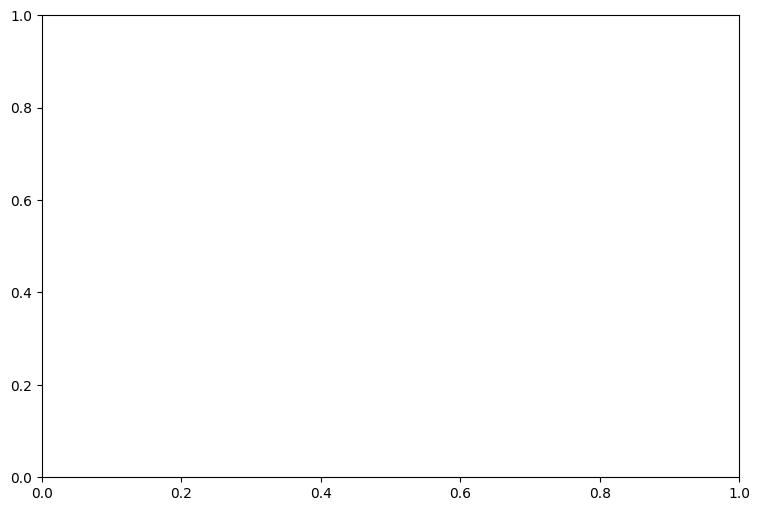

In [104]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_reindexed_ada_tcfl, annot=True, fmt="d", linewidths=.5, ax=ax)

In [ ]:
df_reindexed_ada

In [93]:
df_result_stats_rel = df_result_stats_rel.reset_index().rename({'level_0':'haz_type', 'level_1':'adp_scen'}, axis=1)

In [94]:
df_result_stats_rel

,haz_type,adp_scen,power,healthcare,education,telecom,mobility,people
0,TC,base,0.488776,0.331509,0.351751,0.350159,0.057933,0.065444
1,TC,MS1,0.488756,0.324983,0.351751,0.350159,0.057933,0.065444
2,TC,MS2,0.485337,0.329462,0.345918,0.347167,0.057933,0.065444
3,TC,MS3,0.489362,0.328483,0.351751,0.353197,0.057933,0.065444
4,FL,base,0.020979,0.044168,0.035547,0.006107,0.066929,0.011282
5,FL,MS1,0.020979,0.039938,0.035547,0.006107,0.066929,0.011282
6,FL,MS2,0.000000,0.033708,0.029109,0.002585,0.064872,0.011282
7,FL,MS3,0.007924,0.034652,0.033096,0.004594,0.066304,0.011282
8,TCFL,base,0.490903,0.376194,0.357668,0.350159,0.095967,0.000000
9,TCFL,MS1,0.491779,0.372022,0.357668,0.353197,0.095967,0.076726


In [100]:
df_result_stats_rel = df_result_stats_rel.melt(id_vars=["haz_type", "adp_scen"], 
        var_name="service",value_name="rel_imp" )

In [108]:
df_result_stats_rel.groupby(['adp_scen', 'service'])

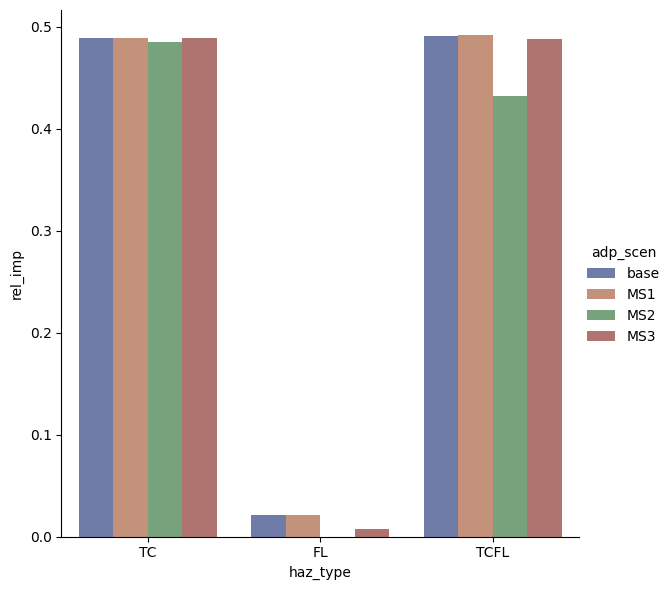

In [103]:
g = sns.catplot(
    data=df_result_stats_rel[df_result_stats_rel.service=='power'], kind="bar",
    x="haz_type", y='rel_imp', hue='adp_scen',  palette="dark", alpha=.6, height=6
)

In [28]:
np.array([vx['Level']>2 for vx in ci_graph_base.graph.vs]).sum()

18

In [24]:
ci_network_base.nodes[(ci_network_base.nodes.ci_type=='health')&
                     (ci_network_base.nodes.Level<3)][['capacity_power_line_health', 'func_internal', 'func_tot']]

,capacity_power_line_health,func_internal,func_tot
478117,-1.0,1,1
478118,-1.0,1,1
478119,-1.0,1,1
478120,-1.0,1,1
478121,-1.0,1,1
...,...,...,...
479152,-1.0,1,1
479153,-1.0,1,1
479154,-1.0,1,1
479155,-1.0,1,1


In [23]:
dict_result_gdfs['TC'][(dict_result_gdfs['TC'].ci_type=='health') &
                       (dict_result_gdfs['TC'].Level>2)]

,ci_type,func_internal,func_tot,imp_dir,geometry,actual_supply_celltower_people,actual_supply_education_people,actual_supply_health_people,actual_supply_power_line_people,actual_supply_road_people,counts,Level
478116,health,0,0,0.600531,POINT (34.87402 -19.85082),0.0,0.0,1.0,0.0,0.0,NaN,4.0
478146,health,0,0,0.600531,POINT (34.87521 -19.84903),0.0,0.0,1.0,0.0,0.0,NaN,4.0
478186,health,1,1,0.000000,POINT (39.87422 -13.10498),0.0,0.0,1.0,0.0,0.0,NaN,4.0
478889,health,1,0,0.000000,POINT (32.58613 -25.93040),0.0,0.0,1.0,0.0,0.0,NaN,4.0
478894,health,1,0,0.000000,POINT (33.00388 -24.52850),0.0,0.0,1.0,0.0,0.0,NaN,3.0
478897,health,1,0,0.000000,POINT (32.54401 -25.94766),0.0,0.0,1.0,0.0,0.0,NaN,4.0
478902,health,0,0,0.429180,POINT (33.47829 -19.10905),0.0,0.0,1.0,0.0,0.0,NaN,3.0
478905,health,1,1,0.000000,POINT (39.26124 -15.12326),0.0,0.0,1.0,0.0,0.0,NaN,4.0
478926,health,1,0,0.000000,POINT (32.43858 -25.96728),0.0,0.0,1.0,0.0,0.0,NaN,3.0
478927,health,1,0,0.000000,POINT (32.61106 -25.94286),0.0,0.0,1.0,0.0,0.0,NaN,4.0


In [22]:
dict_result_stats

{'TC': {'base': {'power': 4548190.939715385,
   'healthcare': 6846158.749721527,
   'education': 6419215.085260391,
   'telecom': 6818894.060367584,
   'mobility': 1151614.9796772003,
   'people': 1929088.979181837},
  'MS1': {'power': 4548004.405387878,
   'healthcare': 6711373.52851963,
   'education': 6419215.085260391,
   'telecom': 6818894.060367584,
   'mobility': 1151614.9796772003,
   'people': 1929088.979181837},
  'MS2': {'power': 4516194.711135864,
   'healthcare': 6803884.530243874,
   'education': 6312767.87796402,
   'telecom': 6760619.23668766,
   'mobility': 1151614.9796772003,
   'people': 1929088.979181837},
  'MS3': {'power': 4553639.554228783,
   'healthcare': 6783657.902076721,
   'education': 6419215.085260391,
   'telecom': 6878039.101071358,
   'mobility': 1151614.9796772003,
   'people': 1929088.979181837}},
 'FL': {'base': {'power': 195211.86215782166,
   'healthcare': 912125.3428468704,
   'education': 648700.7580871582,
   'telecom': 118919.34086608887,
   '

In [35]:
print(access_stat_dict)

print(access_num_dict)

{'power': 0.31567872478360287, 'healthcare': 0.7005959325286107, 'education': 0.6191029345029471, 'telecom': 0.6606395193855589, 'mobility': 0.6743710356608099, 'people': 1.0}
{'power': 9305266.849009514, 'healthcare': 20651477.57416439, 'education': 18249307.16032219, 'telecom': 19473681.741137505, 'mobility': 19878445.867292404, 'people': 29477016.087759018}


In [9]:
np.histogram(gdf_tc[gdf_tc.ci_type=='power_line'].func_internal)

(array([ 215,    0,    0,    0,    0,    0,    0,    0,    0, 9082]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

<AxesSubplot: >

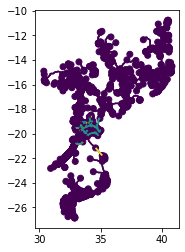

In [15]:
gdf_tc[gdf_tc.ci_type=='power_line'].plot('casc_state')

<AxesSubplot: >

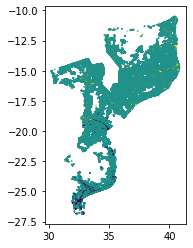

In [17]:
gdf_tc[gdf_tc.ci_type=='people'].plot('actual_supply_power_line_people', markersize=0.1)

In [20]:
gdf_tc[(gdf_tc.ci_type=='people')&(gdf_tc.actual_supply_power_line_people==-1)].counts.sum()

4735476.154543877

In [21]:
gdf_tc[(gdf_tc.ci_type=='people')&(gdf_tc.actual_supply_power_line_people==0)].counts.sum()

20171749.238749504

In [22]:
gdf_tc[(gdf_tc.ci_type=='people')&(gdf_tc.actual_supply_power_line_people==1)].counts.sum()

4569790.694465637

In [ ]:
# for some reason, imp_dir are lost for tc road and tcfl road when casc_state and access state calculated for TCFL
# Don't know why. func_internal and func_tot saved.

<AxesSubplot: >

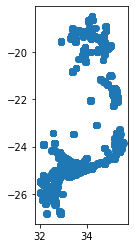

In [23]:
gdf_tc[(gdf_tc.ci_type=='people')&(gdf_tc.actual_supply_power_line_people==-1)].plot()

In [12]:
gdf_tc.groupby('ci_type').imp_dir.mean()

ci_type
celltower       0.029020
education       0.053655
health          0.079560
people          4.032741
power_line     83.252662
power_plant     0.000000
road           31.184471
Name: imp_dir, dtype: float64

In [13]:
gdf_fl.groupby('ci_type').imp_dir.mean()

ci_type
celltower       0.005516
education       0.020046
health          0.008115
people          0.699427
power_line      0.003765
power_plant     0.000000
road           25.577033
Name: imp_dir, dtype: float64

In [52]:
gdf_tc_fl.groupby('ci_type').imp_dir.mean()

ci_type
celltower       0.034536
education       0.073701
health          0.021939
people          0.000000
power_line      0.000000
power_plant     0.000000
road           56.761503
Name: imp_dir, dtype: float64

In [14]:
gdf_tc.groupby('ci_type').func_internal.min()

ci_type
celltower      0
education      0
health         0
people         1
power_line     0
power_plant    1
road           0
Name: func_internal, dtype: int64

In [64]:
gdf_tc.groupby('ci_type').imp_dir.mean()

ci_type
celltower       0.029020
education       0.053655
health          0.013824
people          0.000000
power_line     80.563623
power_plant     0.000000
road           31.184471
Name: imp_dir, dtype: float64

In [63]:
gdf_fl.groupby('ci_type').imp_dir.mean()

ci_type
celltower       0.005516
education       0.020046
health          0.008115
people          0.000000
power_line      0.003765
power_plant     0.000000
road           25.577033
Name: imp_dir, dtype: float64

In [65]:
def make_impact_hists(gdf_fl, gdf_tc, ci_type):
    """ how many infras affected by one vs. both hazards?"""
    bool_dict = {}
    haz_tags = ['FL', 'TC']
    for haz_tag, gdf in zip(haz_tags, [gdf_fl, gdf_tc]):
        bool_dict[haz_tag] = np.array(gdf[gdf.ci_type==ci_type].imp_dir>0)
    bool_dict['FL_only'] =   bool_dict['FL'] & ~bool_dict['TC']
    bool_dict['TC_only'] =   ~bool_dict['FL'] & bool_dict['TC']
    bool_dict['TC_FL'] = bool_dict['FL'] & bool_dict['TC']
    
    return {'FL_only' : bool_dict['FL_only'].astype(int).sum(),
           'TC_only' : bool_dict['TC_only'].astype(int).sum(),
           'TC_FL' : bool_dict['TC_FL'].astype(int).sum()}

In [95]:
def make_func_tot_hists(gdf_fl, gdf_tc, gdf_tc_fl, ci_type):
    """ how many infras dysfunctional ?"""
    bool_dict = {}
    haz_tags = ['FL', 'TC', 'TCFL']
    for haz_tag, gdf in zip(haz_tags, [gdf_fl, gdf_tc, gdf_tc_fl]):
        bool_dict[haz_tag] = np.array(gdf[gdf.ci_type==ci_type].func_tot<1)
    bool_dict['FL_only'] =   bool_dict['FL'] & ~bool_dict['TC']
    bool_dict['TC_only'] =   ~bool_dict['FL'] & bool_dict['TC']
    bool_dict['TC_FL_only'] = bool_dict['TCFL'] & ~bool_dict['FL'] & ~bool_dict['TC']
    bool_dict['TC_FL_both'] = bool_dict['FL'] & bool_dict['TC']
    
    return {'FL_only' : bool_dict['FL_only'].astype(int).sum(),
           'TC_only' : bool_dict['TC_only'].astype(int).sum(),
           'TC_FL_only' : bool_dict['TC_FL_only'].astype(int).sum(),
           'TC_FL_both' : bool_dict['TC_FL_both'].astype(int).sum()}

In [96]:
def make_func_internal_hists(gdf_fl, gdf_tc, gdf_tc_fl, ci_type):
    """ how many infras dysfunctional ?"""
    bool_dict = {}
    haz_tags = ['FL', 'TC', 'TCFL']
    for haz_tag, gdf in zip(haz_tags, [gdf_fl, gdf_tc, gdf_tc_fl]):
        bool_dict[haz_tag] = np.array(gdf[gdf.ci_type==ci_type].func_internal<1)
    bool_dict['FL_only'] =   bool_dict['FL'] & ~bool_dict['TC']
    bool_dict['TC_only'] =   ~bool_dict['FL'] & bool_dict['TC']
    bool_dict['TC_FL_only'] = bool_dict['TCFL'] & ~bool_dict['FL'] & ~bool_dict['TC']
    bool_dict['TC_FL_both'] = bool_dict['FL'] & bool_dict['TC']
    
    return {'FL_only' : bool_dict['FL_only'].astype(int).sum(),
           'TC_only' : bool_dict['TC_only'].astype(int).sum(),
           'TC_FL_only' : bool_dict['TC_FL_only'].astype(int).sum(),
           'TC_FL_both' : bool_dict['TC_FL_both'].astype(int).sum()}

In [66]:
make_impact_hists(gdf_fl, gdf_tc, 'road')

{'FL_only': 0, 'TC_only': 1034480, 'TC_FL': 33744}

<AxesSubplot: >

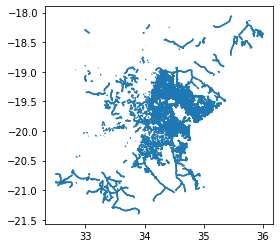

In [89]:
gdf_tc[(gdf_tc.ci_type=='road') & (gdf_tc.func_internal<1)].plot()

In [93]:
np.sum((gdf_fl.ci_type=='road') & (gdf_fl.func_internal<1) & (gdf_tc.func_internal==1))

0

In [97]:
make_func_tot_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'road')

{'FL_only': 0, 'TC_only': 25830, 'TC_FL_only': 0, 'TC_FL_both': 13820}

In [98]:
make_func_internal_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'road')

{'FL_only': 0, 'TC_only': 25830, 'TC_FL_only': 0, 'TC_FL_both': 13820}

In [67]:
make_impact_hists(gdf_fl, gdf_tc, 'power_line')

{'FL_only': 35, 'TC_only': 391, 'TC_FL': 0}

In [99]:
make_func_internal_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'power_line')

{'FL_only': 0, 'TC_only': 221, 'TC_FL_only': 0, 'TC_FL_both': 35}

In [101]:
make_func_tot_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'power_line')

{'FL_only': 0, 'TC_only': 269, 'TC_FL_only': 0, 'TC_FL_both': 35}

In [68]:
make_impact_hists(gdf_fl, gdf_tc, 'health')

{'FL_only': 2, 'TC_only': 99, 'TC_FL': 7}

In [102]:
make_func_tot_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'health')

{'FL_only': 0, 'TC_only': 27, 'TC_FL_only': 0, 'TC_FL_both': 21}

In [103]:
make_func_internal_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'health')

{'FL_only': 0, 'TC_only': 16, 'TC_FL_only': 0, 'TC_FL_both': 9}

In [69]:
make_impact_hists(gdf_fl, gdf_tc, 'education')

{'FL_only': 0, 'TC_only': 266, 'TC_FL': 26}

In [104]:
make_func_tot_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'education')

{'FL_only': 0, 'TC_only': 59, 'TC_FL_only': 0, 'TC_FL_both': 38}

In [105]:
make_func_internal_hists(gdf_fl, gdf_tc, gdf_tc_fl, 'education')

{'FL_only': 0, 'TC_only': 61, 'TC_FL_only': 0, 'TC_FL_both': 26}

In [70]:
make_impact_hists(gdf_fl, gdf_tc, 'celltower')

{'FL_only': 0, 'TC_only': 47, 'TC_FL': 7}

In [71]:
make_impact_hists(gdf_fl, gdf_tc, 'power_plant')

{'FL_only': 0, 'TC_only': 0, 'TC_FL': 0}

In [27]:
bool_dict_rd

{'FL': array([0, 0, 0, ..., 0, 0, 0]),
 'TC': array([1, 1, 1, ..., 1, 1, 1]),
 'TC FL': array([1, 1, 1, ..., 1, 1, 1])}

# Plotting Maps

In [134]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import sys
import os
import glob
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import climada.util.coordinates as u_coords
import pickle
#from climada_petals.engine.networks import nw_utils as nwu
os.chdir('/cluster/project/climate/evelynm/mplotutils') 
import mplotutils as mpu

In [204]:
###########
# Color definitions
###########

class InfraColorMaps:
    def __init__(self):
        self.service_col_dict = {-1. : '#FF5733', 0. : 'grey', 1. : 'green'}
        self.service_col_map = ListedColormap(['#FF5733', 'grey', 'green'])
        self.servicecum_col_dict = {-9. : '#581845', -8. : '#581845',
                                -7. : '#581845', -6. : '#581845',  
                                -5. : '#581845', -4. : '#581845',
                                -3. : '#900C3F', -2. : '#C70039', 
                                -1. : '#FF5733', 0. : 'grey', 
                                 1. : 'green'}
        self.servicecum_col_map = ListedColormap(['#581845',  '#581845',
                                '#581845',  '#581845',  '#581845', '#581845',
                               '#900C3F', '#C70039',  '#FF5733', 'grey', 'green'])
        self.casc_col_dict = {0. : 'blue', 1. : 'magenta', 2. : 'yellow'}
        self.casc_col_map = ListedColormap(['blue','magenta','yellow'])
        self.service_compimp_map = {0: 'gray',
                                   1 : 'green',
                                   -1 : 'orange',
                                   -2 : 'blue',
                                   -3 : 'magenta',
                                   -4 : 'yellow'}

def _two_slope_norm(vmin=-10, vcenter=0, vmax=1):
    """
    Two Slope Norm example from
    https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
    """
    #cols_access = plt.cm.Greens(np.linspace(0.75, 1, 25))
    cols_access = plt.cm.Greens(np.linspace(0.2, 0.3, 10))
    cols_inavail = plt.cm.Greys(np.linspace(0.2, 0.3, 11))
    cols_disrupt = plt.cm.magma(np.linspace(0, 0.75, 20))
    all_colors = np.vstack((cols_disrupt, cols_inavail, cols_access))
    segment_colmap = colors.LinearSegmentedColormap.from_list('service_states', all_colors)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    return segment_colmap, divnorm      
        


In [136]:

def service_dict():
    return {'power_line' : 'electricity infrastructure',
           'celltower' : 'mobile communications infrastructure',
           'health': 'healthcare facilities',
           'education' : 'educational facilities',
           'road' : 'roads',
           'people' : 'population clusters'
           }
def service_dict2():
    return {'power_line' : 'electricity access',
           'celltower' : 'mobile communications access',
           'health': 'healthcare access',
           'education' : 'educational access',
           'road' : 'road access'           }

def _get_extent(gdf):
    buffer_deg = 0.1
    sub_gdf = gdf[gdf.geometry.type == 'Point']
    return (min(sub_gdf.geometry.x)-buffer_deg, max(sub_gdf.geometry.x)+buffer_deg,
                     min(sub_gdf.geometry.y)-buffer_deg, max(sub_gdf.geometry.y)+buffer_deg)

def _get_roadmask(gdf):
    """
    don't plot road access links which were generated during network construction
    in road plots --> input: ci_network.edges
    """
    len_include = len(ci_network_base.edges[(ci_network_base.edges.ci_type=='road') & 
                      ([highway is not None for highway in ci_network_base.edges.highway])]
    )
    return gdf[(gdf.ci_type=='road')][:len_include]


In [19]:
_get_roadmask(dict_result_gdfs['TCFL']['base'])

,ci_type,func_internal,func_tot,imp_dir,geometry,actual_supply_celltower_people,actual_supply_education_people,actual_supply_health_people,actual_supply_power_line_people,actual_supply_road_people,counts,Level,casc_state
6642,road,1,1,0.001517,"LINESTRING (32.56696 -25.87720, 32.56691 -25.8...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
6643,road,1,1,0.001012,"LINESTRING (31.98671 -25.44306, 31.98682 -25.4...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
6644,road,1,1,0.001012,"LINESTRING (32.58872 -25.93126, 32.58837 -25.9...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
6645,road,1,1,0.001517,"LINESTRING (32.60608 -25.90035, 32.60549 -25.9...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
6646,road,1,1,0.001012,"LINESTRING (32.25793 -25.56337, 32.25760 -25.5...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17387,road,1,1,0.003035,"LINESTRING (39.48086 -15.72225, 39.48036 -15.7...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
17388,road,1,1,0.001012,"LINESTRING (32.61680 -25.94831, 32.61690 -25.9...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
17389,road,1,1,0.001012,"LINESTRING (32.61665 -25.94845, 32.61680 -25.9...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
17390,road,1,1,0.001012,"LINESTRING (32.58714 -25.95196, 32.58723 -25.9...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [20]:
def infra_plot(gdf, save_path=None):
    """ all infrastructures in one plot"""
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'power_plant'})
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                          subplot_kw=dict(projection=ccrs.PlateCarree()),
                          figsize=(16,20*1.4142))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        
        if ci_type=='road':
            gdf_rd = _get_roadmask(gdf)
            gdf_rd.plot(ax=ax, markersize=0, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), color='k')
        elif ci_type=='power_line':
            gdf[gdf.ci_type==ci_type].plot(ax=ax, markersize=2, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), color='k')
            gdf[gdf.ci_type=='power_plant'].plot(ax=ax, markersize=4, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), color='k')
        else:
            gdf[gdf.ci_type==ci_type].plot(
                ax=ax, markersize=1, linewidth=0.5, 
                transform=ccrs.PlateCarree(), color='k')
        ax.set_title(f'{service_dict()[ci_type]}', weight='bold', fontsize=17)
    if len(ci_types)%2>0:
        f.delaxes(axes.flatten()[-1])
    #f.suptitle('Infrastructures', weight='bold', fontsize=24)
    f.tight_layout()
    f.subplots_adjust(bottom=0.05, top=0.95)   
    
    if save_path:
        plt.savefig(f'{save_path}'+'infrastructures.png', 
        bbox_inches=None, dpi=300, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
        

In [21]:
def infra_func_plot(gdf, zoom_in=None, save_path=None, event_name=None):
    """ 
    per infrastructure, a plot of functional, destroyed-dysfunctional, 
    cascaded-dysfunctional
    """
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people', 'power_plant'})
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,20*1.4142))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        if zoom_in is None:
            ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        else: 
            ax.set_extent(zoom_in)        
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        if ci_type=='road':
            gdf_rd = _get_roadmask(gdf)
            gdf_rd.plot(ax=ax, markersize=0, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), 
                           color=gdf[gdf.ci_type==ci_type].casc_state.map(
                               InfraColorMaps().casc_col_dict).values.tolist())
        elif ci_type=='power_line':
            # map failed ones on top of functional ones
            gdf[(gdf.ci_type=='power_line') &
            (gdf.geometry.type=='LineString')].plot(ax=ax, markersize=1, linewidth=0.5, 
                                                   transform=ccrs.PlateCarree(), 
                                                    color=gdf[(gdf.ci_type=='power_line') &
                                                (gdf.geometry.type=='LineString')].casc_state.map(
                                               InfraColorMaps().casc_col_dict).values.tolist())
            gdf[(gdf.ci_type=='power_line') &
            (gdf.geometry.type=='Point')].plot(ax=ax, markersize=1, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), 
                                               color=gdf[(gdf.ci_type=='power_line') &
            (gdf.geometry.type=='Point')].casc_state.map(
                               InfraColorMaps().casc_col_dict).values.tolist())
            
            gdf[gdf.ci_type=='power_plant'].plot(ax=ax, markersize=1, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), 
                           color=gdf[gdf.ci_type=='power_plant'].casc_state.map(
                               InfraColorMaps().casc_col_dict).values.tolist())
        else:
            h_casc = ax.scatter(gdf[gdf.ci_type==ci_type].geometry.x, 
                                gdf[gdf.ci_type==ci_type].geometry.y, 
                                c=gdf[gdf.ci_type==ci_type].casc_state,
                                cmap=InfraColorMaps().casc_col_map, 
                                transform=ccrs.PlateCarree(), 
                                s=1.5, vmin=0, vmax=2)
            
        ax.set_title(f'{service_dict()[ci_type]}',
                     weight='bold', fontsize=17)
    
    cbar = mpu.colorbar(
        h_casc, axes.flatten()[-2], size=0.05, pad=0.05, orientation='horizontal')
    cbar.set_ticks([0.33, 1., 1.66])
    cbar.set_ticklabels(['Func.', 'Dysfunc.', 'Casc.'])
    
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
    # f.suptitle(f'Failure states from event {event_name}', weight='bold', fontsize=24)
    f.tight_layout()
    f.subplots_adjust(bottom=0.05, top=0.95)  
    
    if save_path:
        plt.savefig(f'{save_path}'+f'failure_states_{event_name}.png', 
        bbox_inches=None, dpi=300, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
        

In [22]:
def infra_impact_plot(gdf, zoom_in=None, save_path=None, event_name=None):
    """ 
    per infrastructure, a plot of structural damages
    """
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people', 'power_plant'})
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,20*1.4142))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        if zoom_in is None:
            ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        else: 
            ax.set_extent(zoom_in)
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        
        if ci_type=='power_line':
            gdf[gdf.ci_type==ci_type].plot('imp_dir', ax=ax, markersize=1, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0.,
                                           vmax=np.max(gdf[gdf.ci_type==ci_type].imp_dir))
            gdf[gdf.ci_type=='power_plant'].plot('imp_dir', ax=ax, markersize=3, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0., vmax=1.)
            
        elif ci_type=='road':
            gdf_rd = _get_roadmask(gdf)
            gdf_rd.plot('imp_dir', ax=ax, markersize=0, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0., 
                                           vmax=np.max(gdf[gdf.ci_type==ci_type].imp_dir))
            
        else:
            h_imp = ax.scatter(gdf[gdf.ci_type==ci_type].geometry.x, 
                               gdf[gdf.ci_type==ci_type].geometry.y, 
                        c=gdf[gdf.ci_type==ci_type].imp_dir,
                        transform=ccrs.PlateCarree(), s=1.5, vmin=0., vmax=1.)
        ax.set_title(f'{service_dict()[ci_type]}', 
                     weight='bold', fontsize=17)

    cbar = mpu.colorbar(h_imp, axes.flatten()[-2], size=0.05, pad=0.15, 
                        orientation='horizontal')
    cbar.set_label('Structural Damage Frac.')
    #f.suptitle(f'{event_name}', fontsize=24)
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
    f.tight_layout()                                    
    if save_path:
        plt.savefig(f'{save_path}'+f'structural_impacts_{event_name}.png', 
        bbox_inches=None, dpi=300, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [23]:
def service_impact_plot(gdf, save_path=None, event_name=None):
    """
    per basic service, people cluster with and without access to that service
    """
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    services = set([colname for colname in gdf.columns if 'actual_supply_' in colname])
    f, axes = plt.subplots(3, int(np.ceil(len(services)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,20*1.4142))

    for service, ax in zip(services, axes.flatten()[:len(services)]):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        h_serv = ax.scatter(gdf[gdf.ci_type=='people'].geometry.x, 
                            gdf[gdf.ci_type=='people'].geometry.y, 
                            c=gdf[gdf.ci_type=='people'][service],
                            cmap=InfraColorMaps().service_col_map, 
                            transform=ccrs.PlateCarree(), 
                            vmin=-1., vmax=1., s=0.2)
        ax.set_title(f'{service_dict2()[service[14:-7]]}', 
                     weight='bold', fontsize=17)         
                
    cbar = mpu.colorbar(
        h_serv, axes.flatten()[-2], size=0.05, pad=0.05, orientation='horizontal')
    cbar.set_ticks([-0.66, 0., .66])
    cbar.set_ticklabels(['Disr.', 'Inavail.', 'Avail.'])
    
    if len(services)%2>0:
        f.delaxes(axes.flatten()[-1])
    
    #f.suptitle(f'Service Disruptions from event {event_name}', weight='bold', fontsize=24)
    f.subplots_adjust(bottom=0.05, top=0.95)  
    f.tight_layout()                                
    if save_path:
        plt.savefig(f'{save_path}'+f'service_disruptions_{event_name}.png', 
        bbox_inches=None, dpi=300, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [183]:
def _select_impscen(gdf_compimps):
    """
    avail --> 1
    inavail --> 0
    TC --> -1
    FL --> -2
    TC & FL --> -3
    TCFL --> -4
    """
    gdf_compimps['imp_trigger'] = 0
    gdf_compimps.loc[gdf_compimps.TCFL==-1, 
                     'imp_trigger'] = -4
    gdf_compimps.loc[(gdf_compimps.TC==-1)&
                     (gdf_compimps.FL!=-1), 
                     'imp_trigger'] = -1
    gdf_compimps.loc[(gdf_compimps.FL==-1)&
                     (gdf_compimps.TC!=-1), 
                     'imp_trigger'] = -2
    gdf_compimps.loc[(gdf_compimps.FL==-1)&
                     (gdf_compimps.TC==-1), 
                     'imp_trigger'] = -3
    gdf_compimps.loc[gdf_compimps.TCFL==1, 
                     'imp_trigger'] = 1
    return gdf_compimps

In [184]:
gdf_compimps = _select_impscen(gdf_compimps)

In [185]:
gdf_compimps.groupby('imp_trigger').count()

,TC,FL,TCFL,geometry
imp_trigger,,,,
-4,3556,3556,3556,3556
-3,11260,11260,11260,11260
-2,4547,4547,4547,4547
-1,24835,24835,24835,24835
0,271412,271412,271412,271412
1,159854,159854,159854,159854


In [186]:
from matplotlib.lines import Line2D

In [209]:
def service_compoundimpact_plot(gdf_res_dict, service, scenario, save_path=None):
    service_name = f'actual_supply_{service}_people'
    haz_keys = list(gdf_res_dict.keys())
    
    serv_comp_dict = {}
    for haz_type in haz_keys:
        serv_comp_dict[haz_type] = gdf_res_dict[haz_type][
            scenario][gdf_res_dict[haz_type][scenario].ci_type=='people'][service_name].values
    gdf_compimps = pd.DataFrame.from_dict(serv_comp_dict)
    gdf_compimps['geometry'] = serv_comp_dict[haz_type] = gdf_res_dict[haz_keys[0]][
            scenario][gdf_res_dict[haz_keys[0]][scenario].ci_type=='people']['geometry'].values
    gdf_compimps = gpd.GeoDataFrame(gdf_compimps, crs='epsg:4326')
    gdf_compimps = _select_impscen(gdf_compimps)
    
    f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(10,10))
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ax.set_extent(_get_extent(gdf_compimps), ccrs.PlateCarree())
    ax.add_feature(border, facecolor='none', edgecolor='0.5')
    h_serv = ax.scatter(gdf_compimps.geometry.x, gdf_compimps.geometry.y, 
                        c=[InfraColorMaps().service_compimp_map[c] for c in gdf_compimps.imp_trigger], 
                        transform=ccrs.PlateCarree(), s=0.2) #           
    legend_elements = [Line2D([0], [0], marker='o', color = 'w', markerfacecolor='yellow', label='TCFL',
                          markersize=9),
                       Line2D([0], [0], marker='o', color = 'w', markerfacecolor='magenta', label='TC & FL',
                           markersize=9),
                       Line2D([0], [0], marker='o', color = 'w', markerfacecolor='blue', label='FL',
                           markersize=9),
                       Line2D([0], [0], marker='o', color = 'w', markerfacecolor='orange', label='TC',
                           markersize=9),
                       Line2D([0], [0], marker='o', color = 'w', markerfacecolor='gray', label='inavail.',
                          markersize=9),
                       Line2D([0], [0], marker='o', color = 'w', markerfacecolor='green', label='avail.',
                           markersize=9)]
    ax.legend(handles=legend_elements, title='Failure Cause', loc='lower right', frameon=False, 
             fontsize=14, title_fontsize=16)
    
    if save_path:
        plt.savefig(f'{save_path}'+f'{service}_disruptions_imptrigger.png', 
        bbox_inches=None, dpi=300, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    
    plt.show()

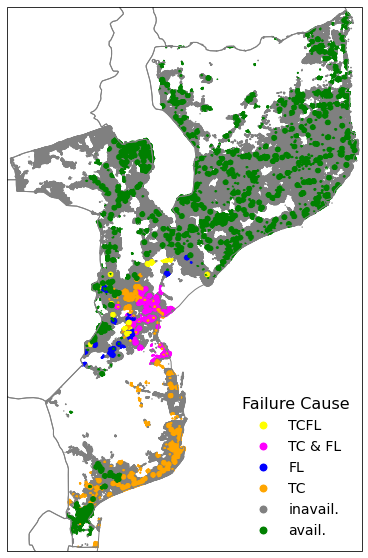

In [210]:
service_compoundimpact_plot(dict_result_gdfs, 'health', 'base', save_path=path_save_plots)

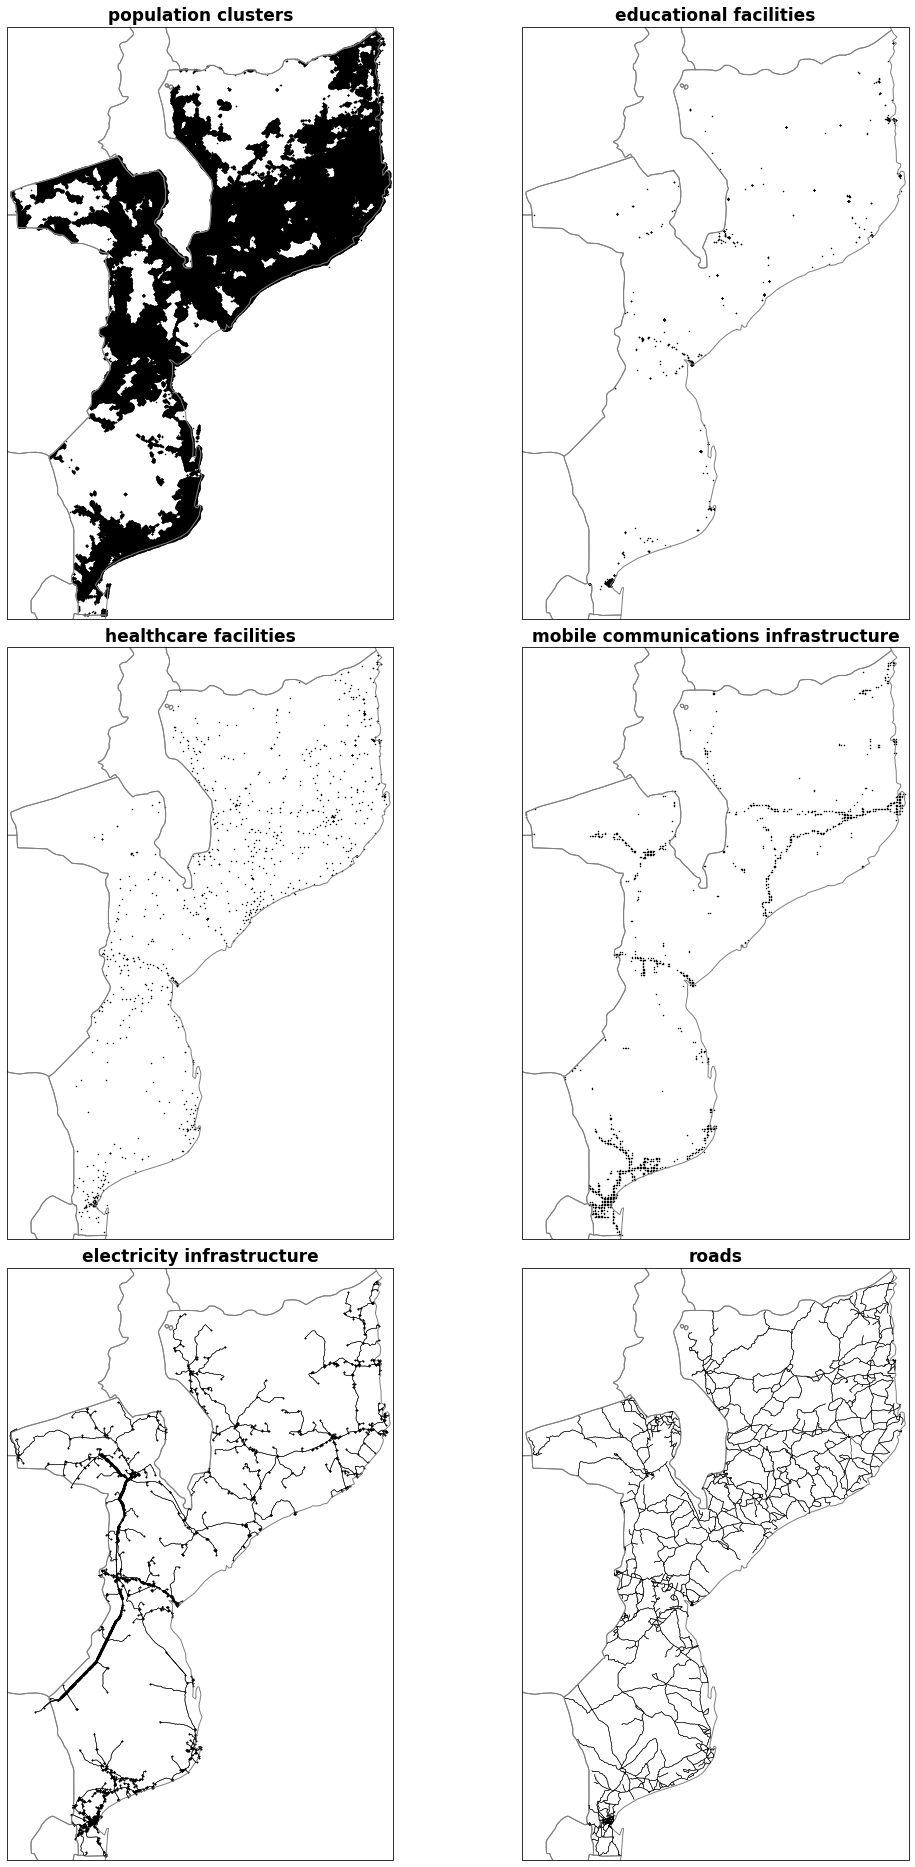

In [75]:
infra_plot(dict_result_gdfs['TCFL']['base'], save_path=path_save_plots)

In [ ]:
infra_impact_plot(dict_result_gdfs['TCFL']['base'], zoom_in=(33.462476, 36.303881, -21.4, -16.609509), save_path=path_save_plots)

In [ ]:
infra_func_plot(dict_result_gdfs['TCFL']['base'], zoom_in=(33.462476, 36.303881, -21.4, -16.609509), save_path=path_save_plots)

In [ ]:
service_impact_plot(dict_result_gdfs['TCFL']['base'], save_path=path_save_plots)



/scratch/tmp.8077915.evelynm/ipykernel_114348/2845169671.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


In [33]:
def load_wind_idai(cntry_shape, storm_id='2019063S18038'):
    "re-compute to 10 mins sustained winds for coherence with impact functions"
    tr_idai = TCTracks.from_ibtracs_netcdf(storm_id=storm_id)
    tr_idai.data[0]['max_sustained_wind']*= 0.88
    tr_idai.equal_timestep()
    min_lat, max_lat, min_lon, max_lon = cntry_shape.bounds[1], cntry_shape.bounds[3], cntry_shape.bounds[0], cntry_shape.bounds[2]
    cent_moz = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.12)
    cent_moz.check()
    tc_idai = TropCyclone.from_tracks(tr_idai, centroids=cent_moz)
    tc_idai.check()
    return tc_idai

def load_flood_idai(path_fl_file):
    fl_idai = Hazard.from_raster([path_fl_file], dst_crs='epsg:4326', haz_type='FL') 
    fl_idai.centroids.set_meta_to_lat_lon() #Hazard('FL').from_raster(path_fl_file)
    fl_idai.event_name = ['Flood_Idai']
    return fl_idai       

def plot_hazard(haz, cntry_shape, savepath, smooth=False):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent((cntry_shape.bounds[0],
                   cntry_shape.bounds[2],
                   cntry_shape.bounds[1],
                   cntry_shape.bounds[3]))
    g = haz.plot_intensity(0,axis=ax,smooth=smooth, cmap='OrRd')
    ax.figure.savefig(savepath, dpi=300)
    plt.show()

In [13]:
import shapely
from climada.hazard.base import Hazard, Centroids
from climada.hazard import TCTracks, TropCyclone
__, cntry_shape = u_coords.get_admin1_info([cntry])
cntry_shape = shapely.ops.unary_union([shp for shp in cntry_shape[iso3]])
tc_idai = load_wind_idai(cntry_shape, storm_id='2019063S18038')

2023-02-01 10:30:14,453 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2022-05-03 17:22:57 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /cluster/work/climate/evelynm/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


In [25]:
fl_idai = load_flood_idai('/cluster/work/climate/evelynm/nw_outputs/MOZ/floodmaks_idai_margherita.tif')

In [29]:
cntry_shape.bounds[[0;2]]

SyntaxError: invalid syntax (361995345.py, line 1)

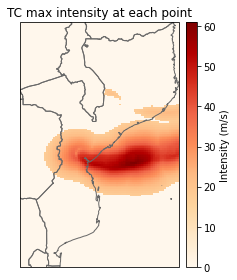

In [34]:
plot_hazard(tc_idai, cntry_shape, path_save_plots+'tc_idai.png')

In [ ]:
plot_hazard(fl_idai, path_save_plots+'fl_idai.png', smooth=True)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
g = fl_idai.plot_intensity(0,axis=ax)
ax.figure.savefig(path_save_plots+'fl_idai.png', dpi=300)
plt.show()

In [24]:
?tc_idai.plot_intensity

In [35]:
from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
poly = cntry_shape

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open(path_proj_folder+'moz_shp.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(poly),
        'properties': {'id': 123},
    })

/scratch/tmp.8169489.evelynm/ipykernel_65261/1033724474.py:16: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xp,yp = shapely.ops.unary_union(cntry_shape[1]).exterior.xy


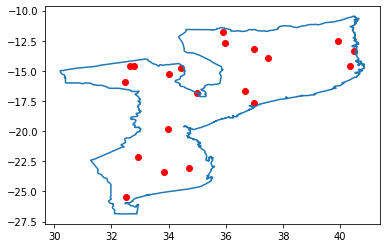

In [42]:
import numpy as np
from shapely.geometry import Point

def Random_Points_in_Polygon(polygon, number):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

points = Random_Points_in_Polygon(cntry_shape, 20)

# Plot the polygon
xp,yp = shapely.ops.unary_union(cntry_shape[1]).exterior.xy
plt.plot(xp,yp)
# Plot the list of points
xs = [point.x for point in points]
ys = [point.y for point in points]
plt.scatter(xs, ys,color="red")
plt.show()

/scratch/tmp.8169489.evelynm/ipykernel_65261/3688336465.py:4: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xp,yp = shapely.ops.unary_union(cntry_shape[1]).exterior.xy


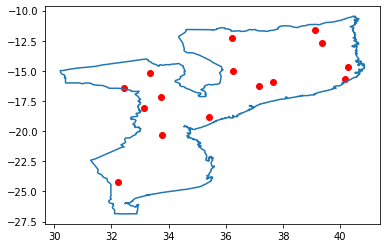

In [47]:
points2 = Random_Points_in_Polygon(cntry_shape, 15)

# Plot the polygon
xp,yp = shapely.ops.unary_union(cntry_shape[1]).exterior.xy
plt.plot(xp,yp)
# Plot the list of points
xs = [point.x for point in points2]
ys = [point.y for point in points2]
plt.scatter(xs, ys,color="red")
plt.show()

In [49]:
states, cntry_shape = u_coords.get_admin1_info([cntry])
pos_state = np.where([state_dict['name_en']=='Sofala' for state_dict in states[iso3]])[0][0]
state_shape = cntry_shape[iso3][pos_state]

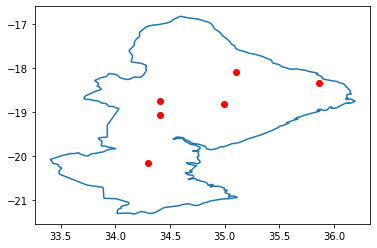

In [54]:
points3 = Random_Points_in_Polygon(state_shape, 6)

# Plot the polygon
xp,yp = shapely.ops.unary_union(state_shape).exterior.xy
plt.plot(xp,yp)
# Plot the list of points
xs = [point.x for point in points3]
ys = [point.y for point in points3]
plt.scatter(xs, ys,color="red")
plt.show()

In [60]:
gdf_health = gpd.GeoDataFrame(geometry=points3, crs='epsg:4326')
gdf_health['ci_type'] = 'health'
gdf_health['Level'] = 3
gdf_health['name'] = 'added_facility'

In [61]:
gdf_health.to_feather(path_proj_folder+'health_sofala_added')

/scratch/tmp.8169489.evelynm/ipykernel_65261/678922745.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf_health.to_feather(path_proj_folder+'health_sofala_added')


In [62]:
gdf_health_orig = gpd.read_feather(path_proj_folder+'locations_preprocessed')
# 6 randomly added hc facilities (of level 3) across sofala
gdf_health_added = gpd.read_feather(path_proj_folder+'health_sofala_added')

In [63]:
gdf_health_orig

,osm_id,amenity,building,healthcare,name,geometry,value,Level
0,5.679247e+08,hospital,None,hospital,Beira Central Hospital,POINT (34.87402 -19.85082),1,4
1,1.911643e+09,hospital,None,None,Hospital Rural de Vilankulos,POINT (35.31999 -21.99428),1,2
2,3.354721e+09,clinic,None,clinic,Muhavire Clinic,POINT (39.26403 -15.12647),1,1
3,3.354721e+09,clinic,None,None,Boa Saude Clinic,POINT (39.26836 -15.13026),1,1
4,3.361338e+09,clinic,None,clinic,LAC Clinic,POINT (39.25817 -15.12286),1,1
...,...,...,...,...,...,...,...,...
1064,NaN,clinic,yes,clinic,Centro de Saúde de Mute,POINT (40.35589 -10.96486),1,1
1065,NaN,hospital,hospital,None,None,POINT (32.47178 -25.96144),1,1
1066,NaN,hospital,hospital,None,None,POINT (32.47222 -25.96140),1,1
1067,NaN,hospital,hospital,None,Hospital Provincial da Matola,POINT (32.43872 -25.96685),1,3


In [64]:
gdf_health_orig.append(gdf_health_added)

,osm_id,amenity,building,healthcare,name,geometry,value,Level,ci_type
0,5.679247e+08,hospital,None,hospital,Beira Central Hospital,POINT (34.87402 -19.85082),1.0,4,NaN
1,1.911643e+09,hospital,None,None,Hospital Rural de Vilankulos,POINT (35.31999 -21.99428),1.0,2,NaN
2,3.354721e+09,clinic,None,clinic,Muhavire Clinic,POINT (39.26403 -15.12647),1.0,1,NaN
3,3.354721e+09,clinic,None,None,Boa Saude Clinic,POINT (39.26836 -15.13026),1.0,1,NaN
4,3.361338e+09,clinic,None,clinic,LAC Clinic,POINT (39.25817 -15.12286),1.0,1,NaN
...,...,...,...,...,...,...,...,...,...
1,NaN,NaN,NaN,NaN,added_facility,POINT (34.29917 -20.15742),NaN,3,health
2,NaN,NaN,NaN,NaN,added_facility,POINT (34.41164 -18.75377),NaN,3,health
3,NaN,NaN,NaN,NaN,added_facility,POINT (35.10243 -18.10381),NaN,3,health
4,NaN,NaN,NaN,NaN,added_facility,POINT (34.99324 -18.82880),NaN,3,health
